## Import Libraries

In [1]:
from mnist import MNIST
from matplotlib import pyplot as plt
import matplotlib.image as img
import numpy as np
import cv2
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

## Load MNIST data

In [2]:
mndata = MNIST('C:\mnist-data')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

In [3]:
np.random.seed(0)
train_idx = np.random.choice(np.arange(len(train_images)), 10000, replace=False)
train_idx = np.uint8(train_idx)
test_idx = np.random.choice(np.arange(len(test_images)), 1000, replace=False)
test_idx = np.uint8(test_idx)

In [4]:
train_images = [np.array(train_images[i]).reshape((28, 28)) for i in train_idx]
test_images = [np.array(test_images[i]).reshape((28, 28)) for i in test_idx]

In [5]:
train_labels = [train_labels[i] for i in train_idx]
test_labels = [test_labels[i] for i in test_idx]

In [6]:
## Helper function to plot images
def plot_imgs(Image1 ,Image2 ,Image3 ,Image4, t1='', t2='', t3='', t4='', axis='on'):
    fig = plt.figure()
    rows = 2
    columns = 2

    fig.add_subplot(rows, columns, 1)

    plt.imshow(Image1, cmap='gray')
    plt.axis(axis)
    plt.title(t1)

    fig.add_subplot(rows, columns, 2)

    plt.imshow(Image2, cmap='gray')
    plt.axis(axis)
    plt.title(t2)

    fig.add_subplot(rows, columns, 3)

    plt.imshow(Image3, cmap='gray')
    plt.axis(axis)
    plt.title(t3)

    fig.add_subplot(rows, columns, 4)

    plt.imshow(Image4, cmap='gray')
    plt.axis(axis)
    plt.title(t4)
    
    plt.show()

MNIST dataset images


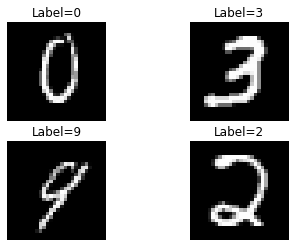

In [10]:
print('MNIST dataset images')
plot_imgs(train_images[0], train_images[1], test_images[2], test_images[10], 'Label='+str(train_labels[0]), 'Label='+str(train_labels[1]), 'Label='+str(test_labels[2]), 'Label='+str(test_labels[10]), 'off')

In [11]:
## function used to calculate TSS threshold for an image 
def tss_thresh(image):
    Z = image.reshape((-1,1))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    label = label.reshape(image.shape)
    bg_label = label[0][0]
    return np.max(image[label==bg_label])

In [12]:
tss_train_images = [tss_thresh(image) for image in train_images]
tss_test_images = [tss_thresh(image) for image in test_images]

In [13]:
## TSS thresholds calculated using tss_thresh function
## TSS thresholds for test images will act as groundtruth for training
print('TSS Thresholds for training images:', tss_train_images[:10], '.....')
print('TSS Thresholds for testing images:', tss_test_images[:10], '.....')

TSS Thresholds for training images: [98, 115, 97, 108, 107, 108, 108, 97, 112, 114] .....
TSS Thresholds for testing images: [107, 64, 96, 98, 106, 107, 91, 110, 98, 103] .....


In [14]:
## function used to generate binary mask of an image given TSS threshold
def fgs(image, thresh):
    res_img = np.zeros(image.shape)
    res_img[image>thresh] = 255
    return res_img

In [15]:
fgs_train_images = [fgs(image, thresh) for image, thresh in zip(train_images, tss_train_images)]
fgs_test_images = [fgs(image, thresh) for image, thresh in zip(test_images, tss_test_images)]

Binary masks


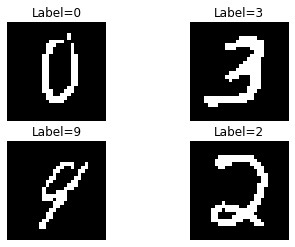

In [17]:
print('Binary masks')
plot_imgs(fgs_train_images[0], fgs_train_images[1], fgs_test_images[2], fgs_test_images[10], 'Label='+str(train_labels[0]), 'Label='+str(train_labels[1]), 'Label='+str(test_labels[2]), 'Label='+str(test_labels[10]), 'off')

## Training DL network for foreground extraction

In [18]:
X_train = list(map(lambda x: x.flatten(), train_images))
X_train = np.array(X_train)
X_test = list(map(lambda x: x.flatten(), test_images))
X_test = np.array(X_test)

y_train = np.array(tss_train_images)
y_test = np.array(tss_test_images)

TSS threshold/y_train for this image: 110


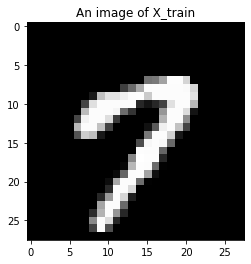

In [23]:
## what a row in X_train and y_train look like for foreground extraction model
plt.imshow(X_train[10].reshape((28, 28)), cmap='gray')
plt.title('An image of X_train')
print('TSS threshold/y_train for this image:', y_train[10])

In [21]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred = np.uint8(y_pred)

Actual TSS threshold: 107 
Predicted TSS threshold: 122


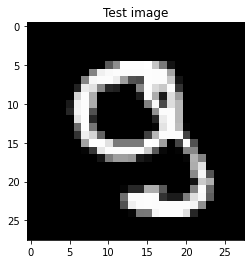

In [29]:
plt.imshow(test_images[5], cmap='gray')
plt.title('Test image')
print('Actual TSS threshold:', y_test[5], '\nPredicted TSS threshold:', y_pred[5])

In [30]:
## function for computing jaccard similarity between two binary maps
def jaccard(img1, img2):
    m, n = img1.shape
    
    intersection = 0
    union = 0
    
    for i in range(m):
        for j in range(n):
            if img1[i][j]==0 and img2[i][j]==0:
                continue
            elif img1[i][j]==255 and img2[i][j]==255:
                intersection += 1
                union += 1
            else:
                union += 1
                
    return intersection/union

## Average Jaccard similarity for predicted and actual foreground segmentation

In [31]:
jac_sim = np.zeros(len(test_images))

for i in range(len(test_images)):
    image = test_images[i]
    t_img = np.zeros((28, 28))
    t_img[image>y_test[i]] = 255 ## <--- t_img is the groundtruth foreground segmentation binary mask
    p_img = np.zeros((28, 28))
    p_img[image>y_pred[i]] = 255 ## <--- p_img is the predicted foreground segmentation binary mask
    jac_sim[i]= jaccard(t_img, p_img) ## <-- computing jaccard similarity b/w grountruth and prediction
    
## Assuming average jaccard similarity counts as accuracy
print("Average Jaccard similarity:", np.mean(jac_sim))

Average Jaccard similarity: 0.9116532940088844


## Tight groundtruth circles that encircle the foreground

In [32]:
## function used to calculate center and radius of minimum enclosing circle
def params(image):
    im = np.uint8(image)
    ret,thresh = cv2.threshold(im,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    cnt = contours[max_index]

    (x, y), radius = cv2.minEnclosingCircle(cnt)
    (x, y), radius = (int(x), int(y)), int(radius)
    
    return [x, y, radius]

In [33]:
params_train_images = [params(image) for image in fgs_train_images]
params_test_images = [params(image) for image in fgs_test_images]

In [34]:
print('Tight circle parameters for training images:', params_train_images[:3], '.....')
print('Tight circle parameters for testing images:', params_test_images[:3], '.....')
print('Format: [x, y, radius]')

Tight circle parameters for training images: [[13, 13, 8], [12, 14, 11], [15, 14, 11]] .....
Tight circle parameters for testing images: [[13, 13, 10], [13, 13, 10], [15, 15, 11]] .....
Format: [x, y, radius]


In [35]:
## function used to draw bounding circle on an image given center and radius
def bcircle(image, param):
    im = image.copy()
    x = param[0]
    y = param[1]
    radius = param[2]
    im = cv2.circle(im, (x, y), radius, (255, 255, 255), 1)
    return im

In [36]:
bcircle_train_images = [bcircle(image, param) for image, param in zip(fgs_train_images, params_train_images)]
bcircle_test_images = [bcircle(image, param) for image, param in zip(fgs_test_images, params_test_images)]

Tight groundtruth circles


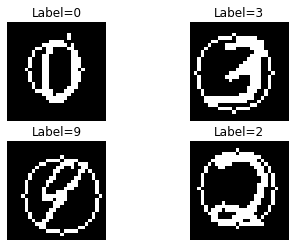

In [38]:
print('Tight groundtruth circles')
plot_imgs(bcircle_train_images[0], bcircle_train_images[1], bcircle_test_images[2], bcircle_test_images[10], 'Label='+str(train_labels[0]), 'Label='+str(train_labels[1]), 'Label='+str(test_labels[2]), 'Label='+str(test_labels[10]), 'off')

## Training for classification + localization

In [39]:
X_train = list(map(lambda x: x.flatten(), fgs_train_images))
X_train = np.array(X_train)
X_test = list(map(lambda x: x.flatten(), fgs_test_images))
X_test = np.array(X_test)

y_train = np.array(train_labels)
y_test = np.array(test_labels)

y_train/Label= 2


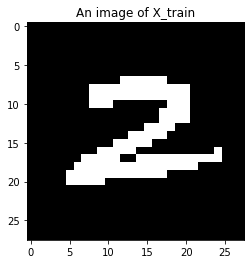

In [42]:
## what a row in X_train and y_train look like for classification model
plt.imshow(X_train[20].reshape((28, 28)), cmap='gray')
plt.title('An image of X_train')
print('y_train/Label=', y_train[20])

In [43]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [44]:
## Marking which test images were classified correctly
correct_pred = [i==j for i, j in zip(y_test, y_pred)]
correct_pred = np.array(correct_pred)

## Semantic Segmentation maps

In [75]:
## function to concatenate 4 images in 2x2 fashion
def concat(img1, img2, img3, img4):
    c_img1 = cv2.hconcat([img1, img2])
    c_img2 = cv2.hconcat([img3, img4])
    c_img = cv2.vconcat([c_img1, c_img2])
    return c_img

In [76]:
## function to make groundtruth semantic segmentation map
## here background pixels will have grayscale value=10 and other pixels will have grayscale value=label 
def sseg(image, label):
    seg_map = 10*np.ones(image.shape)
    seg_map[image==255] = label
    return seg_map

In [77]:
concat_train_images = []

for i in range(0, len(train_images), 4):
    c_img = concat(fgs_train_images[i], fgs_train_images[i+1], fgs_train_images[i+2], fgs_train_images[i+3])
    concat_train_images.append(c_img)
    
concat_test_images = []

for i in range(0, len(test_images), 4):
    c_img = concat(fgs_test_images[i], fgs_test_images[i+1], fgs_test_images[i+2], fgs_test_images[i+3])
    concat_test_images.append(c_img)

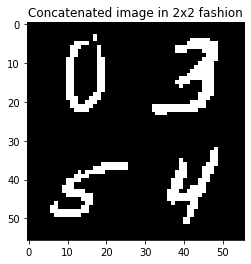

In [78]:
plt.imshow(concat_train_images[0], cmap='gray')
plt.title('Concatenated image in 2x2 fashion')
plt.show()

In [79]:
seg_train_images = []

for i in range(0, len(train_images), 4):
    img1, img2, img3, img4 = sseg(fgs_train_images[i], train_labels[i]), sseg(fgs_train_images[i+1], train_labels[i+1]), sseg(fgs_train_images[i+2], train_labels[i+2]), sseg(fgs_train_images[i+3], train_labels[i+3])
    seg_map = concat(img1, img2, img3, img4)
    seg_train_images.append(seg_map)
    
seg_test_images = []

for i in range(0, len(test_images), 4):
    img1, img2, img3, img4 = sseg(fgs_test_images[i], test_labels[i]), sseg(fgs_test_images[i+1], test_labels[i+1]), sseg(fgs_test_images[i+2], test_labels[i+2]), sseg(fgs_test_images[i+3], test_labels[i+3])
    seg_map = concat(img1, img2, img3, img4)
    seg_test_images.append(seg_map)

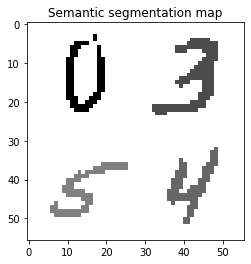

In [80]:
plt.imshow(seg_train_images[0], cmap='gray')
plt.title('Semantic segmentation map')
plt.show()